In [1]:
import sys
sys.path.append("..")
import kdd_utilities as util
from importlib import reload
reload(util)

import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas.tseries.offsets import Week, Day, Hour, Minute
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import BaggingRegressor

import statsmodels.api as sm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt

### 那些有可能要更改的值，以全局变量的形式写在这里

In [2]:
intersection_id = 'A'
tollgate_id = 2
method_num = 0
out_file_name = 'submission_travelTime_' + intersection_id + str(tollgate_id) + '_exploration.csv'
print('out_file_name:', out_file_name)

out_file_name: submission_travelTime_A2_exploration.csv


### 设置路径

In [3]:
path_dataset = '../../dataSets/'
path_training = path_dataset + 'training/'
path_testing_phase1 = path_dataset + 'testing_phase1/'
path_submission = path_dataset + 'submission/'
path_intermediate_results = path_dataset + 'intermediate_results/'
print('path_training: ', path_training)
print('path_testing_phase1: ', path_testing_phase1)
print('path_submission: ', path_submission)
print('path_intermediate_results: ', path_intermediate_results)

path_training:  ../../dataSets/training/
path_testing_phase1:  ../../dataSets/testing_phase1/
path_submission:  ../../dataSets/submission/
path_intermediate_results:  ../../dataSets/intermediate_results/


### 加载 trajectories(table 5)_training.csv，并提取时间序列

,intersection_id,tollgate_id,vehicle_id,starting_time,travel_seq,travel_time
0,B,3,1065642,2016-07-19 00:14:24,105#2016-07-19 00:14:24#9.56;100#2016-07-19 00...,70.85
1,B,3,1047198,2016-07-19 00:35:56,105#2016-07-19 00:35:56#11.58;100#2016-07-19 0...,148.79
2,B,1,1086390,2016-07-19 00:37:15,105#2016-07-19 00:37:15#5.26;100#2016-07-19 00...,79.76
3,A,2,1071181,2016-07-19 00:37:59,110#2016-07-19 00:37:59#13.74;123#2016-07-19 0...,58.05
4,B,1,1065807,2016-07-19 00:56:21,105#2016-07-19 00:56:21#16.08;100#2016-07-19 0...,137.98


time_window_start
2016-07-19 00:00:00    58.05
2016-07-19 00:20:00    58.05
2016-07-19 00:40:00    58.05
2016-07-19 01:00:00    58.05
2016-07-19 01:20:00    56.87
Name: travel_time, dtype: float64

time_window_start
2016-10-17 22:20:00    50.1825
2016-10-17 22:40:00    55.8300
2016-10-17 23:00:00    50.9000
2016-10-17 23:20:00    79.2140
2016-10-17 23:40:00    42.2700
Name: travel_time, dtype: float64

size:  6552


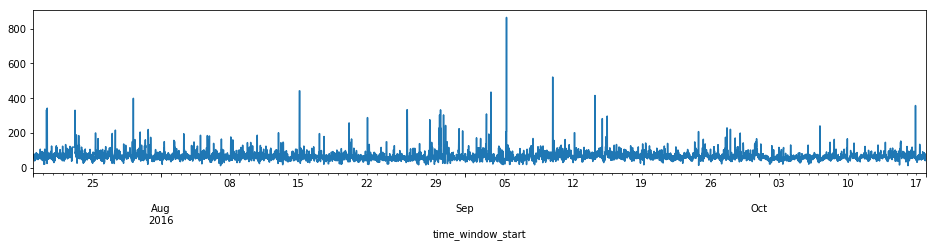

In [4]:
travel_time_training_df = pd.read_csv(path_training + 'trajectories(table 5)_training.csv')
travel_time_training_df.head()

# 提取时间序列
travel_time_training_df.set_index('starting_time', inplace=True)
travel_time_training_df.index = pd.to_datetime(travel_time_training_df.index)
boolean_indexer = (travel_time_training_df['intersection_id'] == intersection_id) & \
    (travel_time_training_df['tollgate_id'] == tollgate_id)
travel_time_training_ts = travel_time_training_df.loc[boolean_indexer, 'travel_time']
# 按时间排序
travel_time_training_ts.sort_index(inplace=True)
# 降采样，20min
travel_time_training_ts_each_20min = travel_time_training_ts.resample('20min').mean().ffill()

# 补齐缺失的 '2016-07-19 00:00:00' 数据
travel_time_training_ts_each_20min = \
    Series({pd.to_datetime('2016-07-19 00:00:00'): \
            travel_time_training_ts_each_20min[0]}).append(travel_time_training_ts_each_20min)
travel_time_training_ts_each_20min.name = 'travel_time'
# 重命名 index 为 'time_window_start'
travel_time_training_ts_each_20min.index.name = 'time_window_start'
# 查看头尾及 size
travel_time_training_ts_each_20min.head()
travel_time_training_ts_each_20min.tail()
print('size: ', travel_time_training_ts_each_20min.size)
# 观察时序图
travel_time_training_ts_each_20min.plot(figsize=(16, 3))
plt.show()

### 剔除异常值

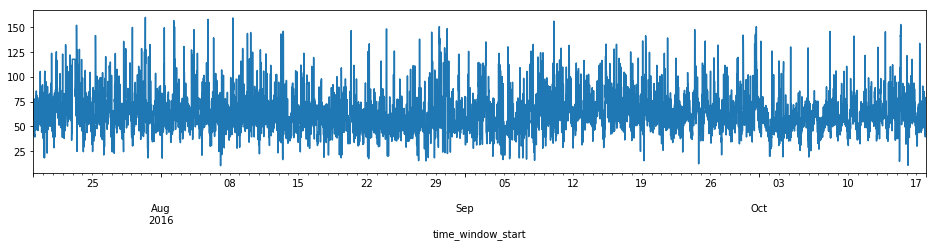

In [5]:
outlier_indexer = \
    (travel_time_training_ts_each_20min - travel_time_training_ts_each_20min.mean()).abs() \
        > 3 * travel_time_training_ts_each_20min.std()
travel_time_training_ts_each_20min[outlier_indexer] = np.nan
travel_time_training_ts_each_20min.fillna(method='ffill', inplace=True)
# 观察时序图
travel_time_training_ts_each_20min.plot(figsize=(16, 3))
plt.show()

### 对比原数据和移动平滑后的数据

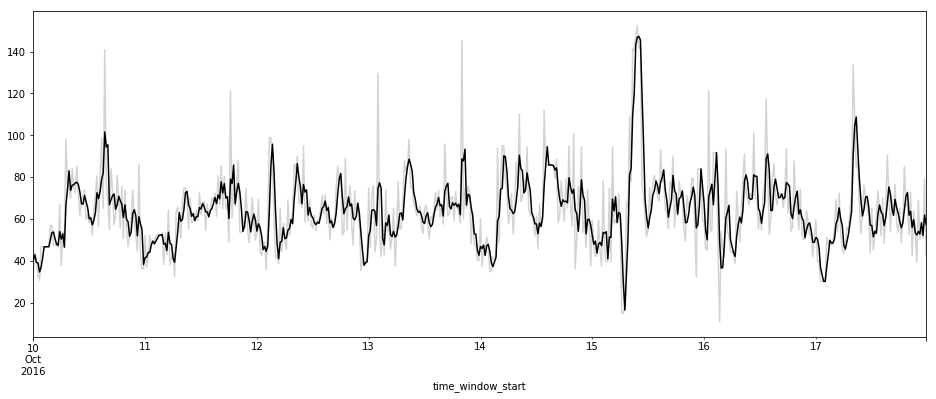

In [6]:
r = travel_time_training_ts_each_20min.rolling(window=3)

travel_time_training_ts_each_20min['2016-10-10':'2016-10-17'].plot(figsize=(16, 6), color='lightgray')
r.mean()['2016-10-10':'2016-10-17'].plot(figsize=(16, 6), style='k-')
plt.show()

### 计算平滑数据的 MAPE

In [7]:
util.mean_absolute_percentage_error(travel_time_training_ts_each_20min['2016-10-10':'2016-10-17'], r.mean())

0.1441225608738035

### 使用平滑数据覆盖原数据

In [8]:
# travel_time_training_ts_each_20min = r.mean()
# travel_time_training_ts_each_20min.fillna(method='bfill', inplace=True)

### ETS 分解

/home/wp/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


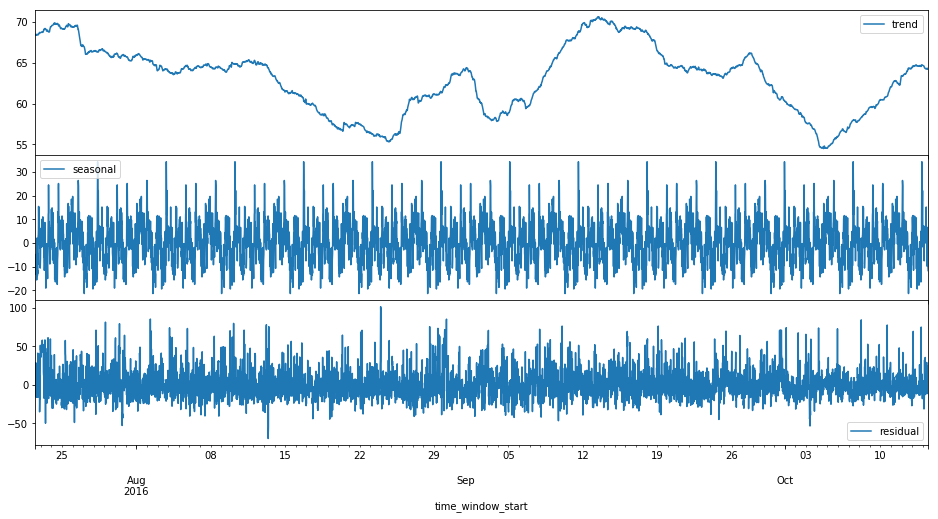

In [9]:
trend_1, seasonal_1, residual_1 = util.ets_decompose(travel_time_training_ts_each_20min, 504)

util.plot_ets(trend_1, seasonal_1, residual_1)

### 保留周期分量

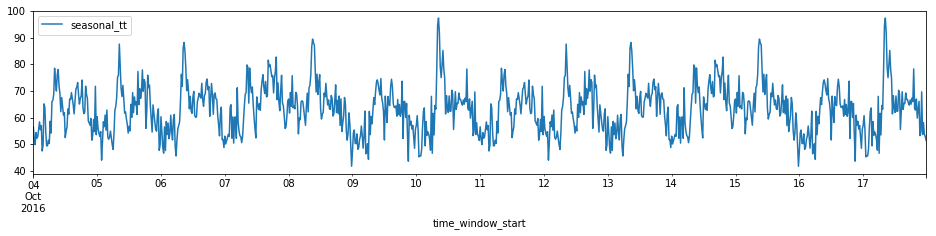

In [10]:
seasonal = seasonal_1 + trend_1.mean() + residual_1.mean()
seasonal.name = 'seasonal_tt'
seasonal['2016-10-04': '2016-10-17'].plot(legend='seasonal',figsize=(16,3))
plt.show()

### MAPE of seasonal

In [11]:
util.mean_absolute_percentage_error(travel_time_training_ts_each_20min.values, seasonal.values)

0.23698704690169223

In [12]:
# seasonally_adjusted_data_1 = trend_1 + residual_1
# seasonally_adjusted_data_1.dropna(inplace=True)
# seasonally_adjusted_data_1.name = 'seasonally_adjusted_data_1'
# seasonally_adjusted_data_1.plot(legend='seasonally_adjusted_data_1',figsize=(16,3))
# plt.show()

### 提取单个周期 [ 2016-10-11: 2016-10-17]

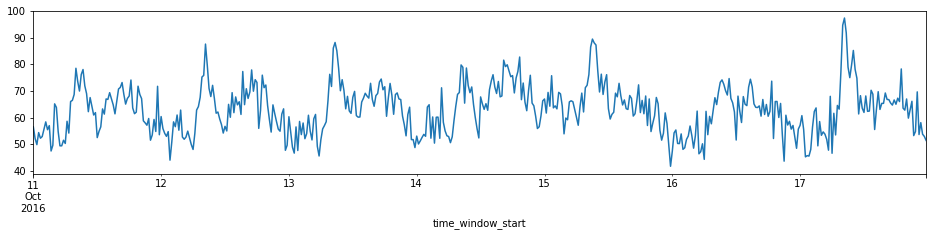

In [13]:
seasonal_one_cycle = seasonal['2016-10-11': '2016-10-17']
seasonal_one_cycle.plot(figsize=(16, 3))
plt.show()

### 平移到 [ 2016-10-18: 2016-10-14]

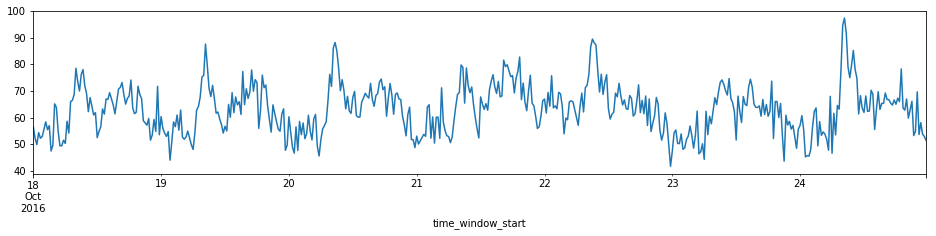

In [14]:
seasonal_test1 = seasonal_one_cycle.copy()
seasonal_test1.index += 1 * Week()
seasonal_test1.plot(figsize=(16, 3))
plt.show()

### 提取前2个小时数据为新特征

In [15]:
travel_time_training_df_each_20min = DataFrame(travel_time_training_ts_each_20min)
for suffix_num in range(6):
    travel_time_training_df_each_20min['prev_tt_' + str(suffix_num)] = 0
for dt_now in travel_time_training_df_each_20min.index[6:]:
    dt_diff = (dt_now.hour * 60 + dt_now.minute) % 120 + 120
    dt_prev = dt_now - dt_diff * Minute()
    travel_time_training_df_each_20min.loc[dt_now, 'prev_tt_0': 'prev_tt_5'] = \
        travel_time_training_ts_each_20min[dt_prev: dt_prev + 100 * Minute()].values
# 将前 2 个小时的数据舍弃
# travel_time_training_df_each_20min = travel_time_training_df_each_20min.loc['2016-07-19 02:00:00':] 
# 将前两个小时的数据补齐，为了方便 Time Series Split
for datetime in pd.date_range('2016-07-19 00:00:00', '2016-07-19 01:40:00', freq='20min'):    
    travel_time_training_df_each_20min.loc[datetime, 'prev_tt_0': 'prev_tt_5'] = \
        seasonal.loc['2016-07-25 22:00:00': '2016-07-25 23:40:00'].values
travel_time_training_df_each_20min.head(12)

,travel_time,prev_tt_0,prev_tt_1,prev_tt_2,prev_tt_3,prev_tt_4,prev_tt_5
time_window_start,,,,,,,
2016-07-19 00:00:00,58.050000,69.642888,53.59822,58.077239,53.737789,52.885262,51.383033
2016-07-19 00:20:00,58.050000,69.642888,53.59822,58.077239,53.737789,52.885262,51.383033
2016-07-19 00:40:00,58.050000,69.642888,53.59822,58.077239,53.737789,52.885262,51.383033
2016-07-19 01:00:00,58.050000,69.642888,53.59822,58.077239,53.737789,52.885262,51.383033
2016-07-19 01:20:00,56.870000,69.642888,53.59822,58.077239,53.737789,52.885262,51.383033
2016-07-19 01:40:00,77.740000,69.642888,53.59822,58.077239,53.737789,52.885262,51.383033
2016-07-19 02:00:00,77.740000,58.050000,58.05000,58.050000,58.050000,56.870000,77.740000
2016-07-19 02:20:00,42.640000,58.050000,58.05000,58.050000,58.050000,56.870000,77.740000
2016-07-19 02:40:00,40.173333,58.050000,58.05000,58.050000,58.050000,56.870000,77.740000


### 加载 weather (table 7)_training.csv 数据
由于在 task2 中已有详细过程，故此处输出从简

In [16]:
weather_training_df = pd.read_csv(path_training + 'weather (table 7)_training.csv')

# 剔除 wind_direction_ts 中的异常值
wind_direction_ts = weather_training_df['wind_direction']
outlier_index = (wind_direction_ts - wind_direction_ts.mean()).abs() > 3 * wind_direction_ts.std()
weather_training_df.loc[outlier_index, 'wind_direction'] = np.nan
weather_training_df['wind_direction'].fillna(method='ffill', inplace=True)

# 设置 index
weather_training_df['time_window_start'] = 0
for i in weather_training_df.index:
    weather_training_df.loc[i, 'time_window_start'] = \
    pd.to_datetime(str(weather_training_df.loc[i, 'date']) + ' ' + str(weather_training_df.loc[i, 'hour']) + ':00:00')
weather_training_df.set_index('time_window_start', inplace=True)
del weather_training_df['date']
del weather_training_df['hour']

# 由于 weather_training_df 的 index 的范围是 [2016-07-01 00:00:00, 2016-10-17 21:00:00]，故重整索引并重采样
datetime_range_training = pd.date_range('2016-07-19 00:00:00', '2016-10-17 23:40:00', freq='20min')
weather_training_df = weather_training_df.reindex(datetime_range_training, method='ffill')

weather_training_df.head()
weather_training_df.tail()

,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
2016-07-19 00:00:00,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0
2016-07-19 00:20:00,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0
2016-07-19 00:40:00,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0
2016-07-19 01:00:00,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0
2016-07-19 01:20:00,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0


,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
2016-10-17 22:20:00,1013.9,1018.9,322.0,2.5,19.3,90.0,0.0
2016-10-17 22:40:00,1013.9,1018.9,322.0,2.5,19.3,90.0,0.0
2016-10-17 23:00:00,1013.9,1018.9,322.0,2.5,19.3,90.0,0.0
2016-10-17 23:20:00,1013.9,1018.9,322.0,2.5,19.3,90.0,0.0
2016-10-17 23:40:00,1013.9,1018.9,322.0,2.5,19.3,90.0,0.0


### 添加天气及其他新特征

In [17]:
# 插入 seasonal_tt
travel_time_training_df_each_20min = travel_time_training_df_each_20min.join(seasonal)
# 插入 seasonal_tt_square
seasonal_tt_square = seasonal ** 2
seasonal_tt_square.name = 'seasonal_tt_square'
travel_time_training_df_each_20min = travel_time_training_df_each_20min.join(seasonal_tt_square)
# 插入 weather
travel_time_training_df_each_20min = travel_time_training_df_each_20min.join(weather_training_df)

# 插入一个 time_window_num, day_of_week 特征
travel_time_training_df_each_20min.index = pd.to_datetime(travel_time_training_df_each_20min.index)
travel_time_training_df_each_20min['time_window_num'] = 0
travel_time_training_df_each_20min['day_of_week'] = 0
for date in travel_time_training_df_each_20min.index:
    travel_time_training_df_each_20min.loc[date, 'time_window_num'] = int((date.hour * 60 + date.minute) / 20)
    travel_time_training_df_each_20min.loc[date, 'day_of_week'] = date.dayofweek
    
# 将 travel_time 移到最后一列
cols = travel_time_training_df_each_20min.columns.tolist()
s = cols[0]
cols = cols[1:] 
cols.append(s)
travel_time_training_df_each_20min = travel_time_training_df_each_20min[cols]

travel_time_training_df_each_20min.head(6)
travel_time_training_df_each_20min.tail(6)

,prev_tt_0,prev_tt_1,prev_tt_2,prev_tt_3,prev_tt_4,prev_tt_5,seasonal_tt,seasonal_tt_square,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,time_window_num,day_of_week,travel_time
time_window_start,,,,,,,,,,,,,,,,,,
2016-07-19 00:00:00,69.642888,53.59822,58.077239,53.737789,52.885262,51.383033,56.499608,3192.205708,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0,0,1,58.05
2016-07-19 00:20:00,69.642888,53.59822,58.077239,53.737789,52.885262,51.383033,52.118574,2716.345747,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0,1,1,58.05
2016-07-19 00:40:00,69.642888,53.59822,58.077239,53.737789,52.885262,51.383033,49.810885,2481.124290,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0,2,1,58.05
2016-07-19 01:00:00,69.642888,53.59822,58.077239,53.737789,52.885262,51.383033,54.336602,2952.466284,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0,3,1,58.05
2016-07-19 01:20:00,69.642888,53.59822,58.077239,53.737789,52.885262,51.383033,52.219889,2726.916821,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0,4,1,56.87
2016-07-19 01:40:00,69.642888,53.59822,58.077239,53.737789,52.885262,51.383033,52.850431,2793.168039,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0,5,1,77.74


,prev_tt_0,prev_tt_1,prev_tt_2,prev_tt_3,prev_tt_4,prev_tt_5,seasonal_tt,seasonal_tt_square,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,time_window_num,day_of_week,travel_time
time_window_start,,,,,,,,,,,,,,,,,,
2016-10-17 22:00:00,52.66,72.693333,42.643333,64.073333,53.825,39.5525,69.642888,4850.131835,1013.9,1018.9,322.0,2.5,19.3,90.0,0.0,66,0,69.0500
2016-10-17 22:20:00,52.66,72.693333,42.643333,64.073333,53.825,39.5525,53.598220,2872.769227,1013.9,1018.9,322.0,2.5,19.3,90.0,0.0,67,0,50.1825
2016-10-17 22:40:00,52.66,72.693333,42.643333,64.073333,53.825,39.5525,58.077239,3372.965736,1013.9,1018.9,322.0,2.5,19.3,90.0,0.0,68,0,55.8300
2016-10-17 23:00:00,52.66,72.693333,42.643333,64.073333,53.825,39.5525,53.737789,2887.750007,1013.9,1018.9,322.0,2.5,19.3,90.0,0.0,69,0,50.9000
2016-10-17 23:20:00,52.66,72.693333,42.643333,64.073333,53.825,39.5525,52.885262,2796.850966,1013.9,1018.9,322.0,2.5,19.3,90.0,0.0,70,0,79.2140
2016-10-17 23:40:00,52.66,72.693333,42.643333,64.073333,53.825,39.5525,51.383033,2640.216078,1013.9,1018.9,322.0,2.5,19.3,90.0,0.0,71,0,42.2700


### 训练集的样本选择（结果不能用于测试集切片）

In [18]:
# 对应于方式 2，用 0810 和 1719 的样本分别训练一个模型
boolean_indexer_0810 = (8 <= travel_time_training_df_each_20min.index.hour)\
    & (travel_time_training_df_each_20min.index.hour < 10)

boolean_indexer_1719 = (17 <= travel_time_training_df_each_20min.index.hour)\
    & (travel_time_training_df_each_20min.index.hour < 19)

# 对应于方式 1，合用 0810 和 1719 的样本训练一个模型
boolean_indexer_0810_1719 = boolean_indexer_0810 | boolean_indexer_1719

# 对应于方式 0，使用所有时间段的样本训练一个模型
boolean_indexer_all = travel_time_training_df_each_20min.index.year != 0

if method_num == 0:
    selected_samples = boolean_indexer_all
else:
    selected_samples = boolean_indexer_0810_1719

### 特征选择（结果可以用于测试集切片）

In [19]:
# 看似很蠢，实则是为了支持任意组合的特征选择，想要剔除某个特征只需要将其注释掉，然后重新运行即可。
selected_features = ['prev_tt_0', 'prev_tt_1', 'prev_tt_2',                  
                     'prev_tt_3', 'prev_tt_4', 'prev_tt_5',
#                      'seasonal_tt',
#                      'seasonal_tt_square',
                     'pressure',
                     'sea_pressure',
                     'wind_direction',
                     'wind_speed', 
                     'temperature',
                     'rel_humidity',
                     'precipitation',
                     'day_of_week',
                     'time_window_num'
                    ]

### 训练集天数选择

In [20]:
trainset_days_num = 77
total_days_num = travel_time_training_df_each_20min.index.size // 72
print('total num of days: ', total_days_num)
print('training set: ', trainset_days_num)
print('testing set: ', total_days_num - trainset_days_num)

total num of days:  91
training set:  77
testing set:  14


### 构建 dataset 和 target

In [21]:
# if method_num != 2:
#     X = travel_time_training_df_each_20min.loc[selected_samples, selected_features].values
#     y = travel_time_training_df_each_20min.loc[selected_samples, 'travel_time'].values
    
#     if method_num == 0:
#         testset_index_begin = trainset_days_num * 72 - 6 # -6 是剪掉数据集最初的那2个小时
#     else:
#         testset_index_begin = trainset_days_num * 12 # 18 * 12 + 1
    
#     X_train = X[:testset_index_begin] 
#     y_train = y[:testset_index_begin]
#     X_test = X[testset_index_begin:]
#     y_test = y[testset_index_begin:]
    
# #     poly = PolynomialFeatures(2)
# #     X_train = poly.fit_transform(X_train)
# #     X_test = poly.transform(X_test)
    
#     scaler = StandardScaler().fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
# else:
#     testset_index_begin = trainset_days_num * 6
    
#     # 0810
#     X_0810 = travel_time_training_df_each_20min.loc[boolean_indexer_0810, selected_features].values
#     y_0810 = travel_time_training_df_each_20min.loc[boolean_indexer_0810, 'travel_time'].values    
    
#     X_train_0810 = X_0810[:testset_index_begin] 
#     y_train_0810 = y_0810[:testset_index_begin]
#     X_test_0810 = X_0810[testset_index_begin:]
#     y_test_0810 = y_0810[testset_index_begin:]
    
#     scaler_0810 = StandardScaler().fit(X_train_0810)
#     X_train_0810 = scaler_0810.transform(X_train_0810)
#     X_test_0810 = scaler_0810.transform(X_test_0810)
    
#     # 1719
#     X_1719 = travel_time_training_df_each_20min.loc[boolean_indexer_1719, selected_features].values
#     y_1719 = travel_time_training_df_each_20min.loc[boolean_indexer_1719, 'travel_time'].values
    
#     X_train_1719 = X_1719[:testset_index_begin] 
#     y_train_1719 = y_1719[:testset_index_begin]
#     X_test_1719 = X_1719[testset_index_begin:]
#     y_test_1719 = y_1719[testset_index_begin:]
    
#     scaler_1719 = StandardScaler().fit(X_train_1719)
#     X_train_1719 = scaler_1719.transform(X_train_1719)
#     X_test_1719 = scaler_1719.transform(X_test_1719)

# # poly = PolynomialFeatures(3)
# # X_scaled = poly.fit_transform(X_scaled)

### Tuning the hyper-parameters of an estimator
A search consists of:

an estimator (regressor or classifier such as sklearn.svm.SVC());----Lasso

a parameter space;----

a method for searching or sampling candidates;----

a cross-validation scheme; and

a score function.----mean_absolute_error


In [57]:
X = travel_time_training_df_each_20min.loc[selected_samples, selected_features].values
y = travel_time_training_df_each_20min.loc[selected_samples, 'travel_time'].values
    
if method_num == 0:
    testset_index_begin = trainset_days_num * 72 # 此处没有 -6
else:
    testset_index_begin = trainset_days_num * 12 # 18 * 12 + 1

X_train = X[:testset_index_begin] 
y_train = y[:testset_index_begin]
X_test = X[testset_index_begin:]
y_test = y[testset_index_begin:]

# poly = PolynomialFeatures(1)
# X_train = poly.fit_transform(X_train)
# X_test = poly.transform(X_test)

# =====尝试 Time Series Split=====

# # 以 2 天的数据作为交叉验证集
# tscv = TimeSeriesSplit(n_splits=37)
# 以 7 天的数据作为交叉验证集
# tscv = TimeSeriesSplit(n_splits=10)
# generator = tscv.split(X_train)
# print('数据集划分：')
# for train, test in tscv.split(X_train):
#     print("%s %s" % (np.shape(train), np.shape(test)))

数据集划分：
(504,) (504,)
(1008,) (504,)
(1512,) (504,)
(2016,) (504,)
(2520,) (504,)
(3024,) (504,)
(3528,) (504,)
(4032,) (504,)
(4536,) (504,)
(5040,) (504,)


In [65]:
InteractiveShell.ast_node_interactivity = "last_expr"

In [37]:
from sklearn.model_selection import cross_val_score, validation_curve
from xgboost import XGBRegressor

In [61]:
loss = make_scorer(util.mean_absolute_percentage_error, greater_is_better=False)
param_range = list(range(1,5,1))
train_scores, valid_scores = \
    validation_curve(XGBRegressor(), X_train, y_train, 'max_depth', param_range, cv=5, scoring=loss, n_jobs=-1)

In [69]:
def plot_validation_curve(train_scores, valid_scores, xlabel, figsize=(12,9)):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    plt.figure(figsize=figsize)
    plt.title("Validation Curve")
    plt.xlabel(xlabel)
    plt.ylabel("Score")
    # plt.ylim(-0.20, -0.23)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

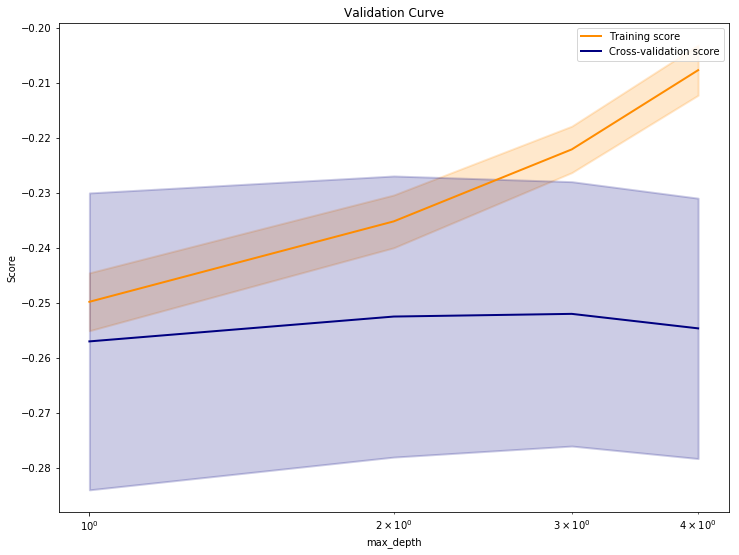

In [70]:
plot_validation_curve(train_scores, valid_scores, 'max_depth')

由此可见`max_depth=2`最好

In [33]:
# loss = make_scorer(util.mean_absolute_percentage_error, greater_is_better=False)
# params = [1,2,3,4,5,6]
# test_scores = []
# for param in params:
#     reg = XGBRegressor(max_depth=param)
#     test_score = np.sqrt(-cross_val_score(reg, X_train, y_train, cv=10, scoring=loss))
#     test_scores.append(np.mean(test_score))

# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.plot(params, test_scores)
# plt.title("max_depth vs CV Error");

In [27]:
# params = [50, 100, 150, 200, 250]
# test_scores = []
# for param in params:
#     reg = XGBRegressor(max_depth=2, n_estimators=param)
#     test_score = np.sqrt(-cross_val_score(reg, X_train, y_train, cv=10, scoring=loss))
#     test_scores.append(np.mean(test_score))

# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.plot(params, test_scores)
# plt.title("max_depth vs CV Error");

In [29]:
reg = XGBRegressor(max_depth=2, n_estimators=200)

In [30]:
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [31]:
loss = make_scorer(util.mean_absolute_percentage_error, greater_is_better=False)
n_alphas = 100
alphas = np.logspace(-10, 10, n_alphas)
# param_grid = {'alpha': alphas, 'normalize': [True, False]}
param_grid = {'alpha': alphas}
# reg = GridSearchCV(Ridge(normalize=True), param_grid, cv=generator, scoring=loss, n_jobs=-1)
reg = GridSearchCV(Lasso(normalize=True), param_grid, cv=generator, scoring=loss, n_jobs=-1)

NameError: name 'generator' is not defined

In [ ]:
reg.fit(X_train, y_train)

In [ ]:
print('best_score_: ', reg.best_score_)
print('MAPE: ', -reg.best_score_)
print('best_params_: ', reg.best_params_)
print('best_index_: ', reg.best_index_)
print('best_estimator_: ', reg.best_estimator_)

In [ ]:
# if method_num != 2:
#     X = travel_time_training_df_each_20min.loc[selected_samples, selected_features].values
#     y = travel_time_training_df_each_20min.loc[selected_samples, 'travel_time'].values
    
#     tscv = TimeSeriesSplit(n_splits=90)
    
#     if method_num == 0:
#         testset_index_begin = trainset_days_num * 72 - 6 # -6 是剪掉数据集最初的那2个小时
#     else:
#         testset_index_begin = trainset_days_num * 12 # 18 * 12 + 1
    
#     X_train = X[:testset_index_begin] 
#     y_train = y[:testset_index_begin]
#     X_test = X[testset_index_begin:]
#     y_test = y[testset_index_begin:]
    
# #     poly = PolynomialFeatures(2)
# #     X_train = poly.fit_transform(X_train)
# #     X_test = poly.transform(X_test)
    
#     scaler = StandardScaler().fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
# else:
#     testset_index_begin = trainset_days_num * 6
    
#     # 0810
#     X_0810 = travel_time_training_df_each_20min.loc[boolean_indexer_0810, selected_features].values
#     y_0810 = travel_time_training_df_each_20min.loc[boolean_indexer_0810, 'travel_time'].values    
    
#     X_train_0810 = X_0810[:testset_index_begin] 
#     y_train_0810 = y_0810[:testset_index_begin]
#     X_test_0810 = X_0810[testset_index_begin:]
#     y_test_0810 = y_0810[testset_index_begin:]
    
#     scaler_0810 = StandardScaler().fit(X_train_0810)
#     X_train_0810 = scaler_0810.transform(X_train_0810)
#     X_test_0810 = scaler_0810.transform(X_test_0810)
    
#     # 1719
#     X_1719 = travel_time_training_df_each_20min.loc[boolean_indexer_1719, selected_features].values
#     y_1719 = travel_time_training_df_each_20min.loc[boolean_indexer_1719, 'travel_time'].values
    
#     X_train_1719 = X_1719[:testset_index_begin] 
#     y_train_1719 = y_1719[:testset_index_begin]
#     X_test_1719 = X_1719[testset_index_begin:]
#     y_test_1719 = y_1719[testset_index_begin:]
    
#     scaler_1719 = StandardScaler().fit(X_train_1719)
#     X_train_1719 = scaler_1719.transform(X_train_1719)
#     X_test_1719 = scaler_1719.transform(X_test_1719)

# # poly = PolynomialFeatures(3)
# # X_scaled = poly.fit_transform(X_scaled)

### 尝试 Univariate feature selection

In [ ]:
# if method_num != 2:
#     selector = SelectKBest(f_regression, k=6)
#     selector.fit(X_train, y_train)
#     print('scores:', selector.scores_.astype(int) )
#     print('pvalues:', selector.pvalues_ )
# else:
#     # 0810
#     selector_0810 = SelectKBest(f_regression, k=6)
#     selector_0810.fit(X_train_0810, y_train_0810)
#     print('scores_0810: ', selector_0810.scores_.astype(int) )
#     print('pvalues_0810: ', selector_0810.pvalues_ )   
#     # 1719
#     selector_1719 = SelectKBest(f_regression, k=6)
#     selector_1719.fit(X_train_1719, y_train_1719)
#     print('scores_1719: ', selector_1719.scores_.astype(int) )
#     print('pvalues_1719: ', selector_1719.pvalues_ ) 

In [ ]:
# if method_num != 2:
#     scores = selector.scores_
#     scores.sort()
#     print(scores.astype(int))
# else:
#     # 0810
#     scores_0810 = selector_0810.scores_
#     scores_0810.sort()
#     print('scores_0810: ', scores_0810.astype(int))
#     # 1719
#     scores_1719 = selector_1719.scores_
#     scores_1719.sort()
#     print('scores_1719: ', scores_1719.astype(int))

### 如果使用的方式0，那么，对 [2016-10-04, 2016-10-17] 期间，每天的 [08:00:00, 09:40:00] 和 [17:00:00, 18:40:00] 进行切片

In [ ]:
if method_num == 0:    
    boolean_indexer_0810_tmp = \
        (travel_time_training_df_each_20min.index >= pd.to_datetime('2016-10-04 00:00:00')) & \
        (travel_time_training_df_each_20min.index <= pd.to_datetime('2016-10-17 23:40:00')) & \
        (travel_time_training_df_each_20min.index.hour >= 8) & \
        (travel_time_training_df_each_20min.index.hour < 10)
    boolean_indexer_1719_tmp = \
        (travel_time_training_df_each_20min.index >= pd.to_datetime('2016-10-04 00:00:00')) & \
        (travel_time_training_df_each_20min.index <= pd.to_datetime('2016-10-17 23:40:00')) & \
        (travel_time_training_df_each_20min.index.hour >= 17) & \
        (travel_time_training_df_each_20min.index.hour < 19)
    boolean_indexer_0810_1719_tmp = boolean_indexer_0810 | boolean_indexer_1719
    
    X_test_0810_1719 = travel_time_training_df_each_20min.loc[boolean_indexer_0810_1719_tmp, selected_features].values
    y_test_0810_1719 = travel_time_training_df_each_20min.loc[boolean_indexer_0810_1719_tmp, 'travel_time'].values
    X_test_0810_1719 = poly.transform(X_test_0810_1719)
#     X_test_0810_1719 = scaler.transform(X_test_0810_1719)

### 拟合模型

In [ ]:
# n_alphas = 200
# alphas = np.logspace(-10, 10, n_alphas)
# if method_num != 2:
#     reg = ElasticNetCV(l1_ratio=1, max_iter=20000, normalize=True)
# #     reg = RidgeCV(alphas)
#     reg.fit(X_train, y_train)
#     y_test_pred = reg.predict(X_test)
# #     y_test_pred -= 9.3
#     print('alpha:', reg.alpha_)    
# else:
#     # 0810
#     reg_0810 = ElasticNetCV(l1_ratio=0.1)
#     reg_0810.fit(X_train_0810, y_train_0810)
#     print('alpha_0810:', reg_0810.alpha_)
#     y_test_pred_0810 = reg_0810.predict(X_test_0810) 
    
#     # 1719
#     reg_1719 = ElasticNetCV(l1_ratio=0.5)
#     reg_1719.fit(X_train_1719, y_train_1719)
#     print('alpha_1719:', reg_1719.alpha_)
#     y_test_pred_1719 = reg_1719.predict(X_test_1719) 

### 观察训练集上的拟合情况

In [ ]:
fig = plt.figure(figsize=(16, 8))
y_train_pred = reg.predict(X_train)
plt.plot(y_train[:504], 'gray')
plt.plot(y_train_pred[:504], 'k')
plt.plot(y_train[:504] - y_train_pred[:504])
# plt.plot(seasonal.values[:504])
# plt.subplots_adjust(hspace=0)
plt.show()
plt.plot(y_train[:72], 'gray')
plt.plot(y_train_pred[:72], 'k')
plt.plot(y_train[:72] - y_train_pred[:72])
# plt.subplots_adjust(hspace=0)
plt.show()
print('MAPE:', util.mean_absolute_percentage_error(y_train, y_train_pred))

### 在测试集上计算 MAPE，以估计模型泛化误差

In [ ]:
if method_num != 2:
    y_test_pred = reg.predict(X_test)
    print('MAPE:', util.mean_absolute_percentage_error(y_test, y_test_pred))
else:
    print('MAPE_0810:', util.mean_absolute_percentage_error(y_test_0810, y_test_pred_0810))
    print('MAPE_1719:', util.mean_absolute_percentage_error(y_test_1719, y_test_pred_1719))

### 观察时序图

In [ ]:
if method_num != 2:
    fig = plt.figure(figsize=(16, 8))
    y_train_pred = reg.predict(X_train)
    plt.plot(y_test[:504], 'lightgray')
    plt.plot(y_test_pred[:504], 'k')
    plt.plot(y_test[:504] - y_train_pred[:504])
#     plt.plot(seasonal['2016-10-4': '2016-10-10'].values, 'gray')
    # plt.subplots_adjust(hspace=0)
    plt.show()
    plt.plot(y_test[:72], 'gray')
    plt.plot(y_test_pred[:72], 'k')
    plt.plot(y_test[:72] - y_train_pred[:72])
    # plt.subplots_adjust(hspace=0)
    plt.show()
else:
    # 0810
    fig = plt.figure(figsize=(16, 3))
    plt.plot(y_test_0810, 'k')
    plt.plot(y_test_pred_0810, 'blue')
    plt.plot(y_test_0810 - y_test_pred_0810)
    # plt.subplots_adjust(hspace=0)
    plt.show()
    
    # 1719
    fig = plt.figure(figsize=(16, 4))
    plt.plot(y_test_1719, 'k')
    plt.plot(y_test_pred_1719, 'blue')
    plt.plot(y_test_1719 - y_test_pred_1719)
    # plt.subplots_adjust(hspace=0)
    plt.show()

#### 思考：如何把这些突变的部分给丫滤掉

### 如果使用的方式0，那么，在 [2016-09-30, 2016-10-17] 期间，每天的 [08:00:00, 09:40:00] 和 [17:00:00, 18:40:00] 上计算 MAPE，以估计提交数据的MAPE

In [ ]:
if method_num == 0:
    y_pred_0810_1719 = reg.predict(X_test_0810_1719 )
#     y_pred_0810_1719 -= 9.3
    print('MAPE:', np.mean(np.abs((y_test_0810_1719 - y_pred_0810_1719) / y_test_0810_1719)))
    
    fig = plt.figure(figsize=(16, 3))
    plt.plot(y_test_0810_1719[:72], 'k')
    plt.plot(y_pred_0810_1719[:72], 'blue')
    plt.plot(y_test_0810_1719[:72] - y_pred_0810_1719[:72])
    # plt.subplots_adjust(hspace=0)
    plt.show()

### Plotting Learning Curves

In [ ]:
# reload(util)
# train_sizes=np.linspace(.1, 1.0, 14)
# generator = tscv.split(X_train)
# loss = make_scorer(util.mean_absolute_percentage_error, greater_is_better=False)
# # train_sizes_abs, train_scores, test_scores = \
# #     learning_curve(Lasso(alpha=reg.best_params_['alpha'], normalize=True), \
# #                    X_train, y_train, cv=generator, n_jobs=4, train_sizes=train_sizes, scoring=loss)
# train_sizes_abs, train_scores, test_scores = \
#     learning_curve(reg.best_estimator_, \
#                    X_train, y_train, n_jobs=4, train_sizes=train_sizes, scoring=loss, cv=10)

In [ ]:
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# InteractiveShell.ast_node_interactivity = 'last_expr'
# plt.figure()
# plt.xlabel("Training examples")
# plt.ylabel("Score")
# plt.grid()
# plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std, \
#                  train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Cross-validation score")
# plt.legend(loc="best")
# plt.show()

### 手动绘制 Learning Curves

In [ ]:
def custom_learning_curve(estimator, X, y):
    error_train_matrix = []
    error_cv_matrix = []
    train_sizes_abs = []
    for i in range(1, 12):
        end = i * 7 * 72 # 不被包含
        train_sizes_abs.append(end)
        X_tmp = X[:end, :]
        y_tmp = y[:end]
        
        tscv = TimeSeriesSplit(n_splits=10)
        generator = tscv.split(X_tmp)
        
        error_train_list = []
        error_cv_list = []
        for index_train, index_cv in generator:
            X_train = X_tmp[index_train]
            y_train = y_tmp[index_train]
            estimator.fit(X_train, y_train)
            y_train_pred = estimator.predict(X_train)
            error_train = util.mean_absolute_percentage_error(y_train, y_train_pred)
            error_train_list.append(error_train)
            
            X_cv = X[index_cv]
            y_cv = y[index_cv]
            X_cv_pred = estimator.predict(X_cv)
            error_cv = util.mean_absolute_percentage_error(y_cv, X_cv_pred)
            error_cv_list.append(error_cv)
        error_train_matrix.append(error_train_list)
        error_cv_matrix.append(error_cv_list)
    return train_sizes_abs, error_train_matrix, error_cv_matrix

In [ ]:
InteractiveShell.ast_node_interactivity = 'last_expr'
train_sizes_abs, error_train_matrix, error_cv_matrix = \
    custom_learning_curve(reg.best_estimator_, X_train, y_train)

In [ ]:
error_train_mean = np.mean(error_train_matrix, axis=1)
error_train_std = np.std(error_train_matrix, axis=1)
error_cv_mean = np.mean(error_cv_matrix, axis=1)
error_cv_std = np.std(error_cv_matrix, axis=1)

plt.figure(figsize=(16, 8))
plt.xlabel("n_samples")
plt.ylabel("MAPE")
plt.grid()
plt.fill_between(train_sizes_abs, error_train_mean - error_train_std, \
                 error_train_mean + error_train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes_abs, error_cv_mean - error_cv_std, error_cv_mean + error_cv_std, alpha=0.1, color="g")
plt.plot(train_sizes_abs, error_train_mean, 'o-', color="r", label="Training MAPE")
plt.plot(train_sizes_abs, error_cv_mean, 'o-', color="g", label="Cross-validation MAPE")
plt.legend(loc="best")
plt.show()

### 加载 trajectories(table 5)_test1.csv 并提取时间序列

In [ ]:
# 加载数据
travel_time_test1_df = pd.read_csv(path_testing_phase1 + 'trajectories(table 5)_test1.csv')
travel_time_test1_df.head()
# 提取时间序列
travel_time_test1_df.set_index('starting_time', inplace=True)
boolean_indexer = (travel_time_test1_df['intersection_id'] == intersection_id) & \
    (travel_time_test1_df['tollgate_id'] == tollgate_id)
travel_time_test1_ts = travel_time_test1_df.loc[boolean_indexer, 'travel_time']
travel_time_test1_ts.index = pd.to_datetime(travel_time_test1_ts.index)
# 按时间排序
travel_time_test1_ts.sort_index(inplace=True)
# 降采样，20min
travel_time_test1_ts_each_20min = travel_time_test1_ts.resample('20min').mean().ffill()
# 切片出所需的部分
boolean_indexer_0810 = (6 <= travel_time_test1_ts_each_20min.index.hour)\
    & (travel_time_test1_ts_each_20min.index.hour < 8)
boolean_indexer_1719 = (15 <= travel_time_test1_ts_each_20min.index.hour)\
    & (travel_time_test1_ts_each_20min.index.hour < 17)
boolean_indexer_0810_1719 = boolean_indexer_0810 | boolean_indexer_1719
travel_time_test1_ts_each_20min = travel_time_test1_ts_each_20min[boolean_indexer_0810_1719]
# 重命名 index 为 'time_window_start'
travel_time_test1_ts_each_20min.index.name = 'time_window_start'
# 查看头尾及 size
travel_time_test1_ts_each_20min.head(6)
travel_time_test1_ts_each_20min.tail(6)
print('shape: ', travel_time_test1_ts_each_20min.shape)
# 观察时序图
travel_time_test1_ts_each_20min.plot(figsize=(16, 3), kind='bar')
plt.show()

### 剔除异常值

In [ ]:
outlier_indexer = \
    (travel_time_test1_ts_each_20min - travel_time_test1_ts_each_20min.mean()).abs() \
        > 3 * travel_time_test1_ts_each_20min.std()
travel_time_test1_ts_each_20min[outlier_indexer] = np.nan
travel_time_test1_ts_each_20min.fillna(method='ffill', inplace=True)
# 观察时序图
travel_time_test1_ts_each_20min.plot(figsize=(16, 3), kind='bar')
plt.show()

### 提取前2个小时数据为新特征

In [ ]:
travel_time_test1_df_each_20min = DataFrame(travel_time_test1_ts_each_20min)
travel_time_test1_df_each_20min.index += 2 * Hour()
for suffix_num in range(6):
    travel_time_test1_df_each_20min['prev_tt_' + str(suffix_num)] = 0
for dt_now in travel_time_test1_df_each_20min.index:
    if 8 <= dt_now.hour <= 9:
        dt_prev = pd.datetime(dt_now.year, dt_now.month, dt_now.day, 6, 0, 0)
    else:
        dt_prev = pd.datetime(dt_now.year, dt_now.month, dt_now.day, 15, 0, 0)
    travel_time_test1_df_each_20min.loc[dt_now, 'prev_tt_0': 'prev_tt_5'] = \
        travel_time_test1_ts_each_20min[dt_prev: dt_prev + 100 * Minute()].values 
travel_time_test1_df_each_20min.head(12)
del travel_time_test1_df_each_20min['travel_time']

### 加载 weather (table 7)_test1.csv 数据
由于在 task2 中已有详细过程，故此处输出从简

In [ ]:
weather_test1_df = pd.read_csv(path_testing_phase1 + 'weather (table 7)_test1.csv')

# 设置 index
weather_test1_df['time_window_start'] = 0
for i in weather_test1_df.index:
    weather_test1_df.loc[i, 'time_window_start'] = \
    pd.to_datetime(str(weather_test1_df.loc[i, 'date']) + ' ' + str(weather_test1_df.loc[i, 'hour']) + ':00:00')
weather_test1_df.set_index('time_window_start', inplace=True)
del weather_test1_df['date']
del weather_test1_df['hour']

# # 由于 weather_training_df 的 index 的范围是 [2016-10-18 00:00:00, 2016-10-24 21:00:00]，故重整索引并重采样
weather_test1_df = weather_test1_df.reindex(travel_time_test1_df_each_20min.index, method='ffill')

weather_test1_df.head(6)
weather_test1_df.tail(6)

### 添加天气及其他新特征

In [ ]:
# 构造 seasonal_tt_test1
seasonal_tt_test1 = seasonal_one_cycle.copy()
seasonal_tt_test1.index += Week()
# 重整索引
seasonal_tt_test1 = seasonal_tt_test1.reindex(travel_time_test1_df_each_20min.index)
# 插入 seasonal_tt_test1
travel_time_test1_df_each_20min = travel_time_test1_df_each_20min.join(seasonal_tt_test1)
# 插入 weather
travel_time_test1_df_each_20min = travel_time_test1_df_each_20min.join(weather_test1_df)

# 插入一个 time_window_num, day_of_week 特征
travel_time_test1_df_each_20min.index = pd.to_datetime(travel_time_test1_df_each_20min.index)
travel_time_test1_df_each_20min['time_window_num'] = 0
travel_time_test1_df_each_20min['day_of_week'] = 0
for date in travel_time_test1_df_each_20min.index:
    travel_time_test1_df_each_20min.loc[date, 'time_window_num'] = int((date.hour * 60 + date.minute) / 20)
    travel_time_test1_df_each_20min.loc[date, 'day_of_week'] = date.dayofweek

travel_time_test1_df_each_20min.head()
travel_time_test1_df_each_20min.tail()

### 预测

In [ ]:
if method_num != 2:
    X_test1 = travel_time_test1_df_each_20min.loc[:, selected_features].values
    X_test1 = poly.transform(X_test1)
#     X_test1 = scaler.transform(X_test1)
#     X_test1 = selector.transform(X_test1)
    y_test1 = reg.predict(X_test1)
    # 绘制时序图
    temp = Series(y_test1, index=travel_time_test1_df_each_20min.index)
    temp.plot(figsize=(16,3), kind='bar')
    plt.show()
else:
    # 0810
    test1_boolean_indexer_0810 = (8 <= volume_test1_df_each_20min_with_new_features.index.hour)\
        & (volume_test1_df_each_20min_with_new_features.index.hour < 10)    
    X_test1_0810 = volume_test1_df_each_20min_with_new_features.loc[test1_boolean_indexer_0810, selected_features].values
    X_test1_0810 = scaler_0810.transform(X_test1_0810)
    y_test1_0810 = reg_0810.predict(X_test1_0810)
    # 绘制时序图
    temp_0810 = Series(y_test1_0810, index=volume_test1_df_each_20min_with_new_features.loc[test1_boolean_indexer_0810].index)
    temp_0810.plot(figsize=(16,3), kind='bar')
    plt.show()
    
    # 1719
    test1_boolean_indexer_1719 = (17 <= volume_test1_df_each_20min_with_new_features.index.hour)\
        & (volume_test1_df_each_20min_with_new_features.index.hour < 19)
    X_test1_1719 = volume_test1_df_each_20min_with_new_features.loc[test1_boolean_indexer_1719, selected_features].values
    X_test1_1719 = scaler_1719.transform(X_test1_1719)
    y_test1_1719  = reg_1719 .predict(X_test1_1719 )
    # 绘制时序图
    temp_1719 = Series(y_test1_1719, index=volume_test1_df_each_20min_with_new_features.loc[test1_boolean_indexer_1719].index)
    temp_1719.plot(figsize=(16,3), kind='bar')
    plt.show()

### 将预测数据写入文件

In [ ]:
reload(util)

if method_num != 2:
    util.to_csv_task1(path_submission, out_file_name, temp, intersection_id, tollgate_id)
else:
    temp_0810 = temp_0810.append(temp_1719, verify_integrity=True)
    temp_0810.sort_index(inplace=True)
    util.to_csv_task1(path_submission, out_file_name, temp_0810, intersection_id, tollgate_id)